# Inspiral Model Test Notebook

## Importing from FEW

In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [2]:
# Below useful for debugging as output from C code will be printed in notebook
#%load_ext wurlitzer

## 1PA Model (SF and PN)

### Trajectory

In [2]:
# initialize trajectory class
traj0PA    = EMRIInspiral(func="SchwarzCirc0PA")
traj1PA    = EMRIInspiral(func="SchwarzCirc1PA")
traj1PAnPN = EMRIInspiral(func="SchwarzCirc1PAnPN")

In [3]:
# set initial parameters
M = 1e6; mu = 3.9e1; p0 = 12.0; e0 = 0.0

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = traj0PA(M, mu, 0.0, p0, e0, 1.0, T=1)

In [4]:
Phi_phi1[-1]

199264.53988381923

In [5]:
t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = traj1PA(M, mu, 0.0, p0, e0, 1.0, T=1)

In [6]:
Phi_phi1[-1]-Phi_phi2[-1]

4.51930908364011

In [7]:
t3, p3, e3, x3, Phi_phi3, Phi_theta3, Phi_r3 = traj1PAnPN(M, mu, 0.0, p0, e0, 1.0, -1.0, T=1)

In [8]:
p3

array([12.        , 11.99999928, 11.99999582, 11.99998073, 11.99992483,
       11.99975909, 11.99930942, 11.99821732, 11.9958132 , 11.99146333,
       11.98285879, 11.96822444, 11.9446995 , 11.90868741, 11.8515513 ,
       11.77815131, 11.68449582, 11.57330141, 11.45808955, 11.3527475 ,
       11.24188001, 11.1268306 , 11.02408654, 10.91764502, 10.80716532,
       10.70878966, 10.60686065, 10.50104838, 10.40557939, 10.30625693,
       10.20305844, 10.11180766, 10.0169384 ,  9.91834836,  9.83118103,
        9.74069755,  9.64664769,  9.5627778 ,  9.47573728,  9.38521153,
        9.30513249,  9.22199746,  9.13549847,  9.05800928,  8.98094059,
        8.89864835,  8.82402495,  8.74641247,  8.66548983,  8.59540594,
        8.52251229,  8.45445227,  8.38362613,  8.3079254 ,  8.25209372,
        8.21055301,  8.16788857,  8.12404363,  8.0760764 ,  8.02655896,
        7.97535524,  7.93829045,  7.90025494,  7.86117996,  7.82854264,
        7.79509318,  7.76080469,  7.72997748,  7.69637016,  7.66

In [9]:
Phi_phi2[-1]

199260.0205747356

In [10]:
Phi_phi3[-1]

199259.9462792539

In [11]:
Phi_phi1[-1]-Phi_phi3[-1]

4.593604565336136

In [12]:
trajFEW = EMRIInspiral(func="SchwarzEccFlux")

In [13]:
t4, p4, e4, x4, Phi_phi4, Phi_theta4, Phi_r4 = trajFEW(M, mu, 0.0, p0, e0, 1.0, T=1)

In [14]:
Phi_phi4[-1]-Phi_phi1[-1]

12.219370467821136

In [15]:
Phi_phi4[-1]

199276.75925428706

### Waveforms

In [70]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# THE FOLLOWING THREAD COMMANDS DO NOT WORK ON THE M1 CHIP, BUT CAN BE USED WITH OLDER MODELS
# EVENTUALLY WE WILL PROBABLY REMOVE OMP WHICH NOW PARALLELIZES WITHIN ONE WAVEFORM AND LEAVE IT TO
# THE USER TO PARALLELIZE FOR MANY WAVEFORMS ON THEIR OWN.

# set omp threads one of two ways
# num_threads = 4

# this is the general way to set it for all computations
# from few.utils.utility import omp_set_num_threads
# omp_set_num_threads(num_threads)

In [71]:
class FastSchwarzschildCirc0PA(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc0PA"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [72]:
class FastSchwarzschildCirc1PA(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc1PA"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [73]:
class FastSchwarzschildCirc1PAnPN(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc1PAnPN"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [74]:
test0 = FastSchwarzschildCirc0PA()
test1 = FastSchwarzschildCirc1PA()
test1PN = FastSchwarzschildCirc1PAnPN()

In [75]:
M = 1e6
mu = 3.9e1
p0 = 12.0
e0 = 0.0
theta = np.pi/3.
phi = np.pi/4.
dist = 1.0

T = 1
dt = 15.0

In [76]:
wave0 = test0(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

wave1 = test1(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

In [24]:
wave1PA0PN = test1PN(M, mu, p0, e0, theta, phi, 0.0, dist=dist, dt=dt, T=T)

In [25]:
wave1PA1PN = test1PN(M, mu, p0, e0, theta, phi, 1.0, dist=dist, dt=dt, T=T)

In [26]:
wave1PA2PN = test1PN(M, mu, p0, e0, theta, phi, 2.0, dist=dist, dt=dt, T=T)

In [27]:
wave1PA3PN = test1PN(M, mu, p0, e0, theta, phi, 3.0, dist=dist, dt=dt, T=T)

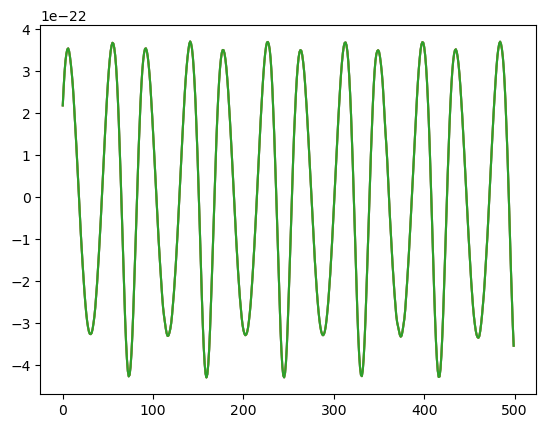

In [32]:
plt.plot(wave0.real[:500])
plt.plot(wave1.real[:500])
plt.plot(wave1PA0PN.real[:500])

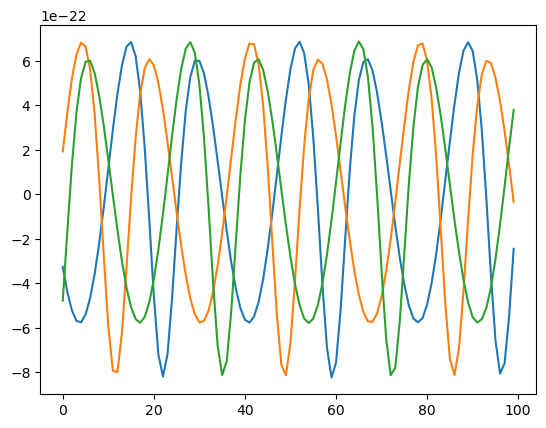

In [29]:
plt.plot(wave0.real[-100:])
plt.plot(wave1.real[-100:])
plt.plot(wave1PA2PN.real[-100:])

In [30]:
len(wave0)

2103877

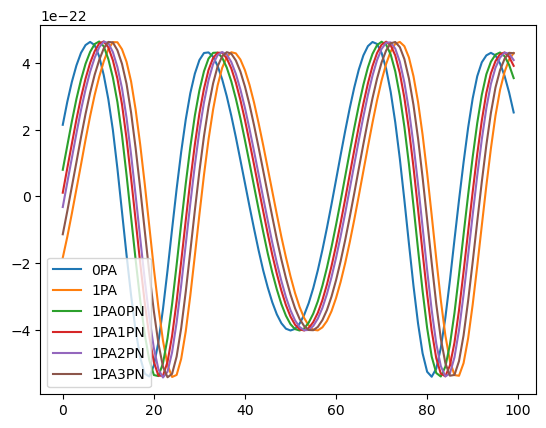

In [31]:
plt.plot(wave0.real[1500000:1500100])
plt.plot(wave1.real[1500000:1500100])
plt.plot(wave1PA0PN.real[1500000:1500100])
plt.plot(wave1PA1PN.real[1500000:1500100])
plt.plot(wave1PA2PN.real[1500000:1500100])
plt.plot(wave1PA3PN.real[1500000:1500100])
plt.legend(['0PA','1PA','1PA0PN','1PA1PN','1PA2PN','1PA3PN'])
plt.savefig('quasi-circular-0PA-1PA-1PAnPN.pdf')

## Look at 0PA vs 0PAnPN

In [33]:
traj1 = EMRIInspiral(func="SchwarzCirc0PA")
traj4 = EMRIInspiral(func="SchwarzCirc0PAnPN")

In [34]:
# set initial parameters
M = 1e6; mu = 3.9e1; p0 = 12.0; e0 = 0.0

In [35]:
t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = traj1(M, mu, 0.0, p0, e0, 1.0, T=1)
t4, p4, e4, x4, Phi_phi4, Phi_theta4, Phi_r4 = traj4(M, mu, 0.0, p0, e0, 1.0, 10.0, T=1)

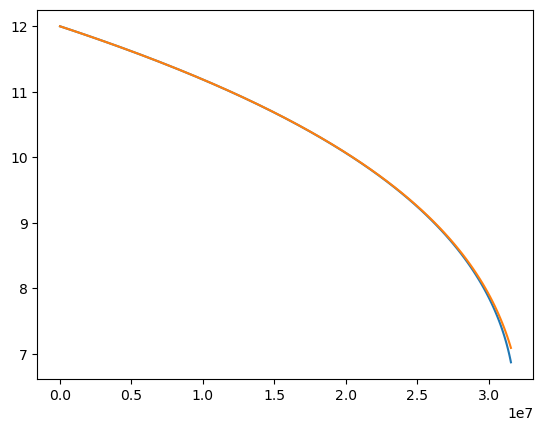

In [36]:
plt.plot(t1,p1)
plt.plot(t4,p4)

In [37]:
Phi_phi1[-1] - Phi_phi4[-1]

506.6770454653306

In [38]:
class FastSchwarzschildCirc0PAnPN(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc0PAnPN"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

## Ignore below for now

In [35]:
# M = 30
# mu = 3
# p0 = 12.0
# e0 = 0.0
# theta = np.pi/3.
# phi = np.pi/4.
# dist = 1.0

# T = 3e-9
# dt = 2e-9

# wave2 = test0(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

In [36]:
# plt.plot(wave2.real[-5000000:])

In [35]:
few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    # num_threads=num_threads,  # 2nd way for specific classes
)

In [13]:
M = 1e6
mu = 3.9e1
p0 = 12.0
e0 = 0.0
theta = np.pi/3.
phi = np.pi/4.
dist = 1.0

T = 1
dt = 15.0

waveFEW = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, dist=dist)

In [14]:
plt.plot(wave0.real[:500])
plt.plot(wave1.real[:500])
plt.plot(waveFEW.real[:500])

NameError: name 'wave0' is not defined

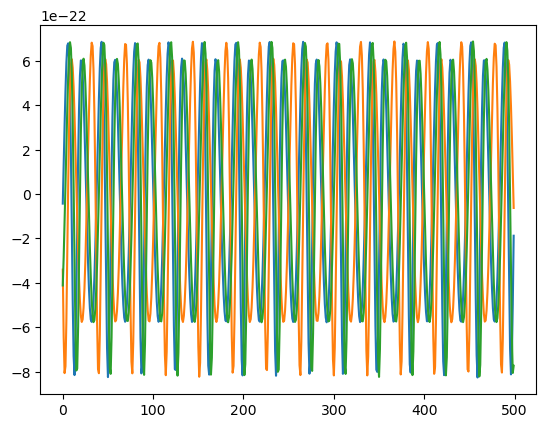

In [20]:
plt.plot(wave0.real[-500:])
plt.plot(wave1.real[-500:])
plt.plot(waveFEW.real[-500:])

## ToDo (mostly done):

- Add $\epsilon$ and $\nu$ 0/1PA models (for $\nu$ use conversion between $\epsilon$ and $\nu$)
- Create 0PA + 1PAnPN models to see how high n needs to be to reduce biases 

## Eccentric case

In [39]:
trajFEW = EMRIInspiral(func="SchwarzEccFlux")
trajEcc0PAnPNq = EMRIInspiral(func="SchwarzEcc0PAnPNq")

In [40]:
M = 1e6; mu = 5e1; p0 = 12.0; e0 = 0.5

t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = trajFEW(M, mu, 0.0, p0, e0, 1.0, T=1)

In [41]:
t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = trajEcc0PAnPNq(M, mu, 0.0, p0, e0, 1.0, 0.0, T=1)

In [42]:
t3, p3, e3, x3, Phi_phi3, Phi_theta3, Phi_r3 = trajEcc0PAnPNq(M, mu, 0.0, p0, e0, 1.0, 9.0, T=1)

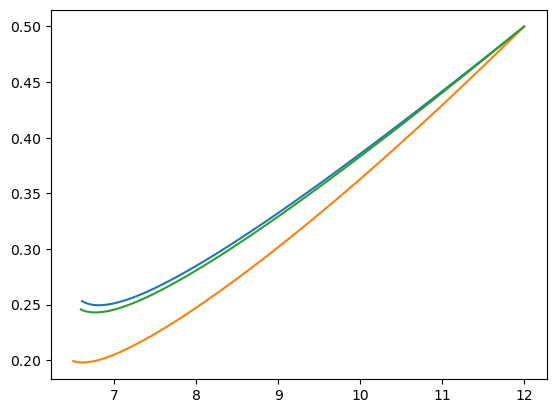

In [43]:
plt.plot(p1,e1)
plt.plot(p2,e2)
plt.plot(p3,e3)

In [44]:
Phi_phi1[-1] - Phi_phi3[-1]

-1326.41420396787

In [45]:
Phi_r1[-1] - Phi_r3[-1]

-729.8794959846855

In [46]:
p3

array([12.        , 11.99999919, 11.99999532, 11.99997969, 11.99992561,
       11.99973551, 11.99925929, 11.99794438, 11.99494011, 11.98894835,
       11.9764197 , 11.95219443, 11.91345018, 11.84639006, 11.74846166,
       11.64365241, 11.53460425, 11.43448139, 11.32916176, 11.21947308,
       11.12162742, 11.01996084, 10.91412641, 10.81825175, 10.71860853,
       10.61484637, 10.52228269, 10.42609712, 10.32594916, 10.23579806,
       10.14208927, 10.0444802 ,  9.95697991,  9.86599471,  9.77118084,
        9.68662782,  9.59849689,  9.50660992,  9.42504752,  9.34017096,
        9.25163697,  9.17318095,  9.0914964 ,  9.00623984,  8.93099485,
        8.85260934,  8.77073951,  8.69906092,  8.62435484,  8.54628102,
        8.47810184,  8.40699843,  8.33263193,  8.26806333,  8.20067967,
        8.13837052,  8.07330853,  8.01335767,  7.95072363,  7.89326791,
        7.83321028,  7.77823303,  7.72073293,  7.66829652,  7.61342168,
        7.56350063,  7.51122274,  7.46392448,  7.4143612 ,  7.36

## 1PA with Spinning Secondary

### Trajectory Tests

In [2]:
traj0PA    = EMRIInspiral(func="SchwarzCirc0PA")
traj1PA    = EMRIInspiral(func="SchwarzCirc1PA")
traj1PASpin = EMRIInspiral(func="SchwarzCirc1PASpin")

In [3]:
# set initial parameters
M = 1e6; mu = 3.9e1; a = 0.; p0 = 12.0; e0 = 0.0; x0 = 1.0; 

# Values of the dimensionless secondary spin
s1 = 0.
s2 = 1.

t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = traj0PA(M, mu, a, p0, e0, x0, T=1)
t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = traj1PA(M, mu, a, p0, e0, x0, T=1)

In [4]:
# Values of the dimensionless secondary spin
s = 0.

# 1PA with secondary spin but s = 0
# Secondary spin is an additional arg, so goes after x0, but before optional args
t3, p3, e3, x3, Phi_phi3, Phi_theta3, Phi_r3 = traj1PASpin(M, mu, a, p0, e0, x0, s, T=1)

# Should be the same as the 1PA model with no spin
Phi_phi2[-1] - Phi_phi3[-1]

0.0

In [5]:
# Values of the dimensionless secondary spin
s = 1.

t4, p4, e4, x4, Phi_phi4, Phi_theta4, Phi_r4 = traj1PASpin(M, mu, a, p0, e0, x0,s, T=1) 

# We should now see a dephasing due to the spin on the secondary
Phi_phi2[-1] - Phi_phi4[-1] 

-2.0061780980904587

### Waveform Tests

#### Setup and Definitions

In [6]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

In [7]:
class FastSchwarzschildCirc0PA(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc0PA"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [8]:
class FastSchwarzschildCirc1PA(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc1PA"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [9]:
class FastSchwarzschildCirc1PASpin(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):
        
        inspiral_kwargs["func"] = "SchwarzCirc1PASpin"

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            EMRIInspiral,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [10]:
waveform0PA= FastSchwarzschildCirc0PA()
waveform1PA = FastSchwarzschildCirc1PA()
waveformSpin = FastSchwarzschildCirc1PASpin()

#### Waveform Calculations

In [11]:
M = 1e6
mu = 3.9e1
p0 = 12.0
e0 = 0.0
theta = np.pi/3.
phi = np.pi/4.
dist = 1.0

T = 1
dt = 15.0

In [12]:
wave0PA = waveform0PA(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

In [13]:
wave1PA = waveform1PA(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

In [14]:
spin = 0.0
waveNoSpin =  waveformSpin(M, mu, p0, e0, theta, phi,spin, dist=dist, dt=dt, T=T)

In [15]:
spin = 1.
waveAllignedSpin =  waveformSpin(M, mu, p0, e0, theta, phi,spin, dist=dist, dt=dt, T=T)

In [16]:
spin = -1.
waveAntiAllignedSpin =  waveformSpin(M, mu, p0, e0, theta, phi,spin, dist=dist, dt=dt, T=T)

#### Plots

Initially, all these waveforms should overlap

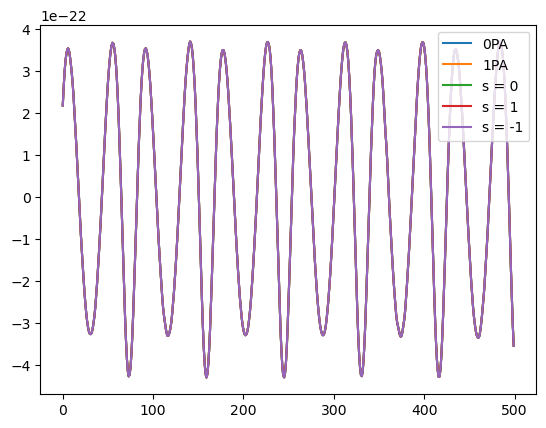

In [17]:
plt.plot(wave0PA.real[:500],label='0PA')
plt.plot(wave1PA.real[:500],label='1PA')
plt.plot(waveNoSpin.real[:500],label='s = 0')
plt.plot(waveAllignedSpin.real[:500],label='s = 1')
plt.plot(waveAntiAllignedSpin.real[:500],label='s = -1')
plt.legend(loc = "upper right")

Then we should start to see some dephasing about half way through

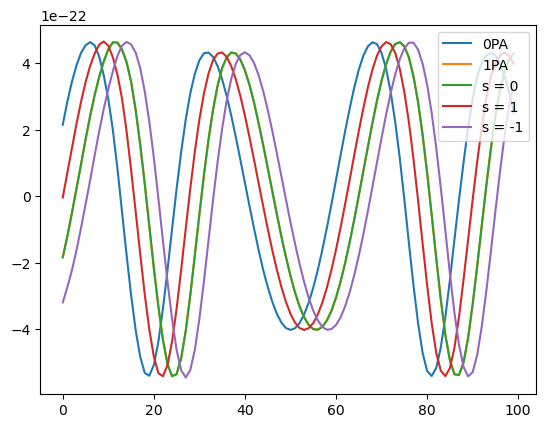

In [18]:
plt.plot(wave0PA.real[1500000:1500100],label='0PA')
plt.plot(wave1PA.real[1500000:1500100],label='1PA')
plt.plot(waveNoSpin.real[1500000:1500100],label='s = 0')
plt.plot(waveAllignedSpin.real[1500000:1500100],label='s = 1')
plt.plot(waveAntiAllignedSpin.real[1500000:1500100],label='s = -1')
plt.legend(loc = "upper right")

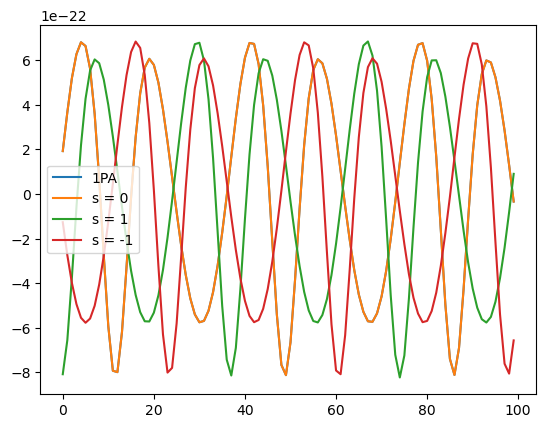

In [19]:
#plt.plot(wave0PA.real[-100:],label='0PA')
plt.plot(wave1PA.real[-100:],label='1PA')
plt.plot(waveNoSpin.real[-100:],label='s = 0')
plt.plot(waveAllignedSpin.real[-100:],label='s = 1')
plt.plot(waveAntiAllignedSpin.real[-100:],label='s = -1')
plt.legend(loc = "best")

Note that 1PA and s = 0 cases overlap completely, as expected.

#### Mismatches

In [20]:
get_mismatch(wave1PA, waveNoSpin)

0.0

In [21]:
get_mismatch(wave1PA, waveAllignedSpin)

0.38892658401529434

In [22]:
get_mismatch(wave1PA, waveAntiAllignedSpin)

0.3888994806958136

In [23]:
get_mismatch(waveAllignedSpin, waveAntiAllignedSpin)

0.531974346116673

* As expected, the spinning model with s = 0 recovers the 1PA model. 
* The mismatch between the 1PA and the s = 1 and s = -1 cases is roughly the same
* But the s = 1 and s = -1  cases differ substantially.

# Check 0PAnPN eccentric model reduces to circular model for $e=0$

The below does not work because (i) the circular model uses nu rather than q and (ii) the circular model re-expands terms in the chain rule whereas the eccentric model does not.

In [2]:
# set initial parameters
M = 1e6; mu = 3.9e1; p0 = 12.0;

In [3]:
trajCirc0PAnPN = EMRIInspiral(func="SchwarzCirc0PAnPN")

In [4]:
tC, pC, eC, xC, Phi_phiC, Phi_thetaC, Phi_rC = trajCirc0PAnPN(M, mu, 0.0, p0, 0, 1.0, 0.0, T=0.5)

In [5]:
trajEcc0PAnPNq = EMRIInspiral(func="SchwarzEcc0PAnPNq")

In [6]:
tE, pE, eE, xE, Phi_phiE, Phi_thetaE, Phi_rE = trajEcc0PAnPNq(M, mu, 0.0, p0, 0, 1.0, 0.0, T=0.5)

In [9]:
pE

array([12.        , 11.99999924, 11.99999543, 11.99998048, 11.99992718,
       11.99977692, 11.99938504, 11.99846617, 11.99629559, 11.99208415,
       11.98429532, 11.9697397 , 11.94618209, 11.90871789, 11.85495935,
       11.7759154 , 11.67644873, 11.56177036, 11.44290149, 11.33391154,
       11.22102909, 11.10390136, 10.99860223, 10.88950238, 10.77625218,
       10.67448434, 10.56888043, 10.49618009])

In [10]:
pC

array([12.        , 11.99999941, 11.99999659, 11.99998483, 11.99994298,
       11.99982325, 11.99947883, 11.9987123 , 11.996997  , 11.99367965,
       11.98736513, 11.97616257, 11.95807021, 11.93236248, 11.89598511,
       11.84523896, 11.76923123, 11.66425916, 11.53574234, 11.40278068,
       11.26499807, 11.14017364, 11.01100635, 10.94285908])